=== 🌍 LAND COVER - TUNISIE (Shapefile) ===
✅ Shapefile chargé : 52059 entités
📐 CRS : EPSG:4326
📋 Colonnes : ['AREA_M2', 'ID', 'GRIDCODE', 'LCCCode', 'geometry']

--- Aperçu des données ---
     AREA_M2  ID  GRIDCODE                  LCCCode  \
0  3110936.0   1       210             7001 // 8001   
1   982723.0   3        20              0003 / 0004   
2   151388.0   2        30             0004 // 0003   
3   151391.0   6       120  21454 // 21446 // 21450   
4   151391.0   4        70             21499-121340   

                                            geometry  
0  POLYGON ((8.89941 37.52083, 8.89923 37.52117, ...  
1  POLYGON ((8.94028 37.52361, 8.94028 37.52917, ...  
2  POLYGON ((8.94583 37.53472, 8.94861 37.53472, ...  
3  POLYGON ((8.91528 37.52917, 8.91528 37.53194, ...  
4  POLYGON ((8.93194 37.53194, 8.9375 37.53194, 8...  

--- Types de données ---
AREA_M2      float64
ID             int32
GRIDCODE       int32
LCCCode       object
geometry    geometry
dtype: object

===

C:\Users\pc\AppData\Local\Temp\ipykernel_16952\3983184679.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_classes, y=col, x="Proportion (%)", palette="viridis")


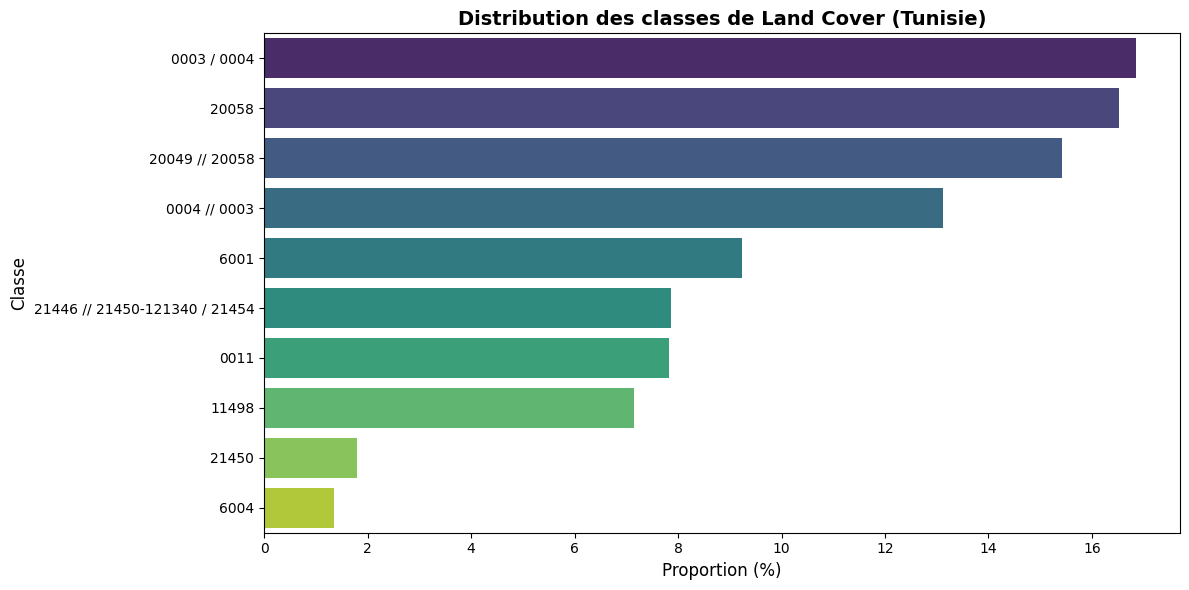

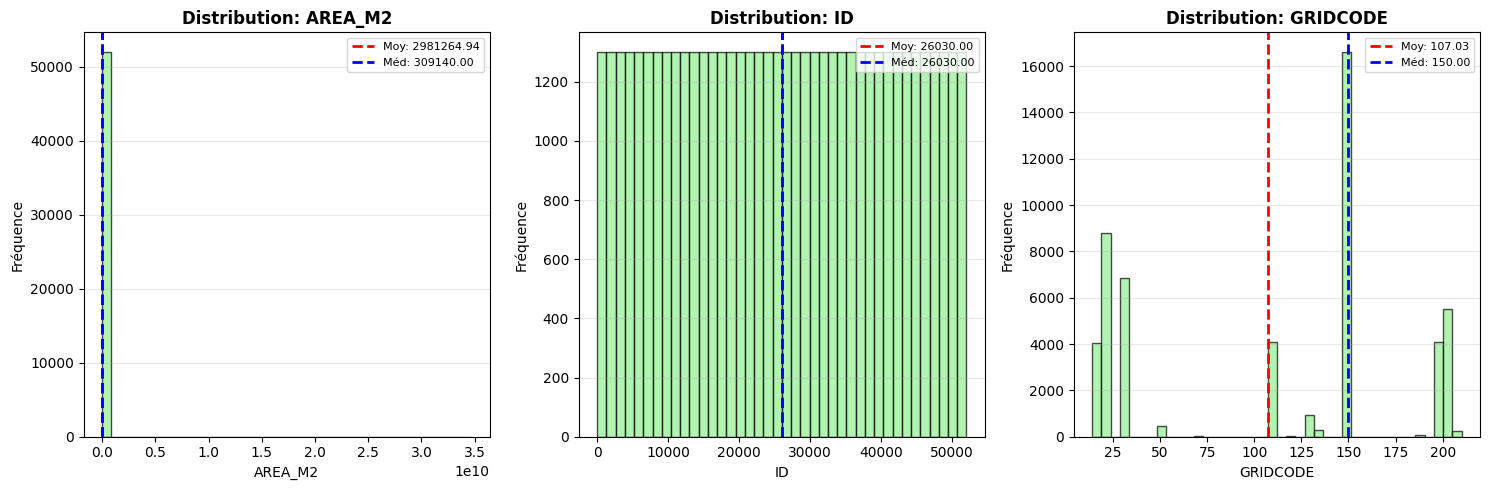

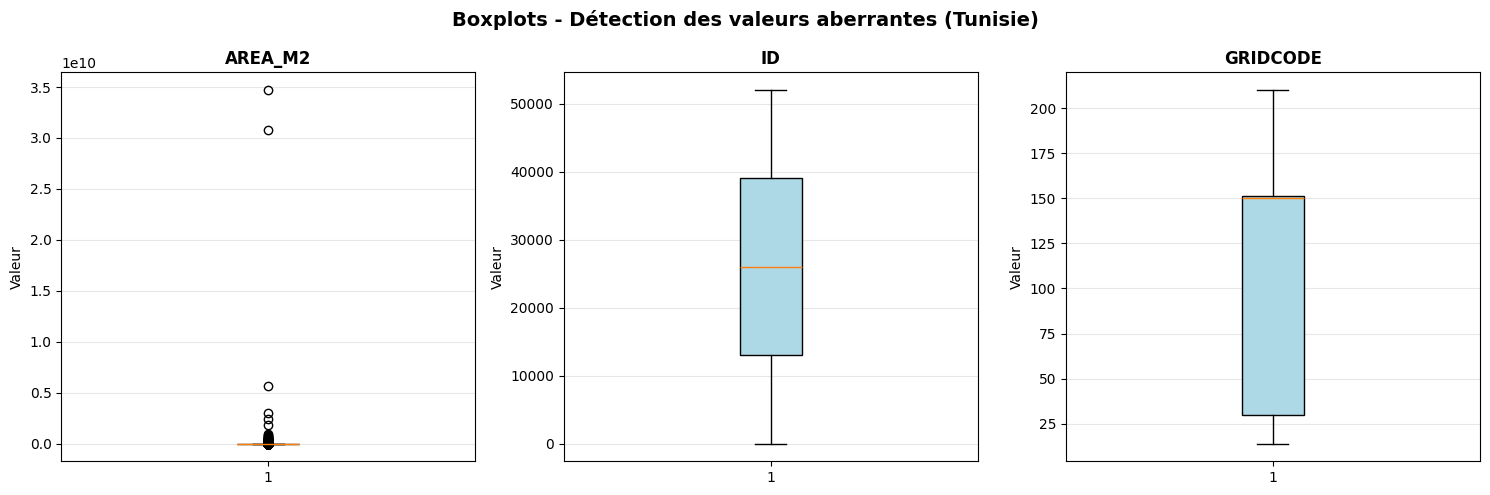


🗺️ Génération de la carte géographique...


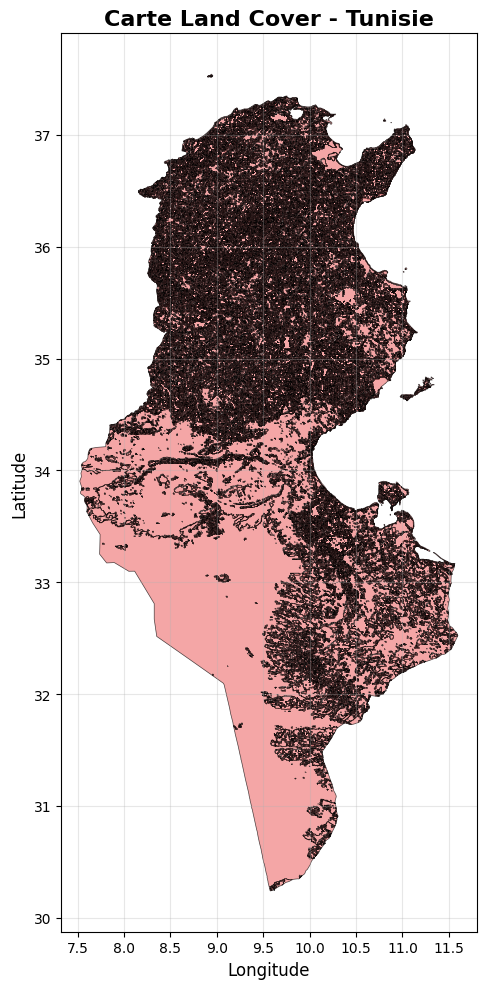


✅ Sauvegarde des données pour preprocessing...
📊 Colonnes catégorielles identifiées : ['LCCCode']
📊 Colonnes numériques identifiées : ['AREA_M2', 'ID', 'GRIDCODE']
📊 Outliers détectés : voir outliers_df ci-dessus

✅ PART 1 TERMINÉE - EDA complétée


In [3]:
# ========== PART 1: DATA LOADING & EDA - TUNISIE (Shapefile) ==========
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

# Chemins
landcover_path = r"C:\Users\pc\Desktop\DM\datasets\landcover"
tunisia_landcover_path = os.path.join(landcover_path, "tun_gc_adg.shp")

# Chargement des données
print("="*70)
print("=== 🌍 LAND COVER - TUNISIE (Shapefile) ===")
print("="*70)

tunisia_landcover = gpd.read_file(tunisia_landcover_path)
print(f"✅ Shapefile chargé : {len(tunisia_landcover)} entités")
print(f"📐 CRS : {tunisia_landcover.crs}")
print(f"📋 Colonnes : {tunisia_landcover.columns.tolist()}")

print("\n--- Aperçu des données ---")
print(tunisia_landcover.head())

print("\n--- Types de données ---")
print(tunisia_landcover.dtypes)

# ========== DATA QUALITY ASSESSMENT ==========
print("\n" + "="*70)
print("=== 📊 ÉVALUATION DE LA QUALITÉ DES DONNÉES ===")
print("="*70)

# 1. COMPLETENESS - Valeurs manquantes
print("\n1️⃣ COMPLÉTUDE (Completeness):")
missing = (tunisia_landcover.isna().sum() / len(tunisia_landcover)) * 100
missing_df = pd.DataFrame({
    'Colonne': missing.index,
    'Valeurs manquantes (%)': missing.values
}).sort_values('Valeurs manquantes (%)', ascending=False)

if missing_df['Valeurs manquantes (%)'].sum() == 0:
    print("✅ Aucune valeur manquante détectée - Complétude: 100%")
else:
    print(missing_df[missing_df['Valeurs manquantes (%)'] > 0])

# 2. CONSISTENCY - Doublons
print("\n2️⃣ COHÉRENCE (Consistency):")
# Exclure la colonne geometry pour la détection des doublons
cols_for_duplicates = [col for col in tunisia_landcover.columns if col != 'geometry']
duplicates = tunisia_landcover.duplicated(subset=cols_for_duplicates).sum()
print(f"📋 Nombre de doublons détectés (hors geometry) : {duplicates}")
if duplicates > 0:
    print(f"⚠️ Supprimer {duplicates} doublons pour améliorer la cohérence")
    tunisia_landcover = tunisia_landcover.drop_duplicates(subset=cols_for_duplicates)
    print("✅ Doublons supprimés")

# Identification des colonnes
cat_cols = [col for col in tunisia_landcover.select_dtypes(include='object').columns if col != 'geometry']
num_cols = tunisia_landcover.select_dtypes(include=np.number).columns.tolist()

print(f"\n📊 Colonnes catégorielles : {cat_cols}")
print(f"📊 Colonnes numériques : {num_cols}")

# ========== DÉTECTION DES OUTLIERS ==========
print("\n" + "="*70)
print("=== 🔍 DÉTECTION DES VALEURS ABERRANTES (IQR Method) ===")
print("="*70)

outliers_summary = []
if len(num_cols) > 0:
    print("\n📊 Statistiques descriptives (colonnes numériques) :")
    desc = tunisia_landcover[num_cols].describe().transpose()
    print(desc)
    
    for col in num_cols:
        Q1 = tunisia_landcover[col].quantile(0.25)
        Q3 = tunisia_landcover[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((tunisia_landcover[col] < lower_bound) | (tunisia_landcover[col] > upper_bound)).sum()
        outliers_pct = (outliers / len(tunisia_landcover)) * 100
        outliers_summary.append({
            'Variable': col,
            'Outliers': outliers,
            'Pourcentage (%)': round(outliers_pct, 2),
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })
    
    outliers_df = pd.DataFrame(outliers_summary)
    print("\n🔍 Résumé des outliers :")
    print(outliers_df)

# ========== VISUALISATIONS EDA ==========
print("\n" + "="*70)
print("=== 📈 ANALYSE EXPLORATOIRE DES DONNÉES (EDA) ===")
print("="*70)

# 1. Distribution des classes catégorielles
if len(cat_cols) > 0:
    col = cat_cols[0]
    print(f"\n📋 Répartition des classes pour '{col}' :")
    freq = tunisia_landcover[col].value_counts().reset_index()
    freq.columns = [col, "Count"]
    freq["Proportion (%)"] = (freq["Count"] / freq["Count"].sum()) * 100
    print(freq.head(15))
    
    # Graphique barplot
    plt.figure(figsize=(12, 6))
    top_classes = freq.head(10)
    sns.barplot(data=top_classes, y=col, x="Proportion (%)", palette="viridis")
    plt.title(f"Distribution des classes de Land Cover (Tunisie)", fontsize=14, fontweight='bold')
    plt.xlabel("Proportion (%)", fontsize=12)
    plt.ylabel("Classe", fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(landcover_path, "tunisia_classes_barplot.png"), dpi=300)
    plt.show()

# 2. Histogrammes avec statistiques
if len(num_cols) > 0:
    n_cols_plot = len(num_cols)
    n_rows = (n_cols_plot + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols_plot > 1 else [axes]
    
    for idx, col in enumerate(num_cols):
        data = tunisia_landcover[col].dropna()
        if len(data) > 0:
            axes[idx].hist(data, bins=40, edgecolor='black', color='lightgreen', alpha=0.7)
            axes[idx].set_title(f"Distribution: {col}", fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel("Fréquence")
            axes[idx].grid(axis='y', alpha=0.3)
            
            mean_val = data.mean()
            median_val = data.median()
            axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moy: {mean_val:.2f}')
            axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Méd: {median_val:.2f}')
            axes[idx].legend(fontsize=8)
    
    for idx in range(len(num_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(landcover_path, "tunisia_histograms.png"), dpi=300)
    plt.show()

# 3. Boxplots pour outliers
if len(num_cols) > 0:
    n_box = min(len(num_cols), 5)
    fig, axes = plt.subplots(1, n_box, figsize=(15, 5))
    if n_box == 1:
        axes = [axes]
    
    for idx, col in enumerate(num_cols[:n_box]):
        data = tunisia_landcover[col].dropna()
        if len(data) > 0:
            bp = axes[idx].boxplot(data, vert=True, patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor('lightblue')
            axes[idx].set_title(col, fontweight='bold')
            axes[idx].set_ylabel("Valeur")
            axes[idx].grid(axis='y', alpha=0.3)
    
    plt.suptitle("Boxplots - Détection des valeurs aberrantes (Tunisie)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(landcover_path, "tunisia_boxplots.png"), dpi=300)
    plt.show()

# 4. Carte géographique
print("\n🗺️ Génération de la carte géographique...")
fig, ax = plt.subplots(figsize=(12, 10))
tunisia_landcover.plot(ax=ax, color="lightcoral", edgecolor="black", linewidth=0.5, alpha=0.7)
ax.set_title("Carte Land Cover - Tunisie", fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(landcover_path, "tunisia_map.png"), dpi=300)
plt.show()

# Sauvegarder les données brutes pour la prochaine étape
print("\n✅ Sauvegarde des données pour preprocessing...")
print(f"📊 Colonnes catégorielles identifiées : {cat_cols}")
print(f"📊 Colonnes numériques identifiées : {num_cols}")
print(f"📊 Outliers détectés : voir outliers_df ci-dessus")
print("\n✅ PART 1 TERMINÉE - EDA complétée")
print("="*70)

In [4]:
# ========== PART 2: DATA PREPROCESSING - TUNISIE ==========
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Chemins
landcover_path = r"C:\Users\pc\Desktop\DM\datasets\landcover"
tunisia_landcover_path = os.path.join(landcover_path, "tun_gc_adg.shp")

# Chargement des données
tunisia_landcover = gpd.read_file(tunisia_landcover_path)

# Suppression des doublons 
cols_for_duplicates = [col for col in tunisia_landcover.columns if col != 'geometry']
tunisia_landcover = tunisia_landcover.drop_duplicates(subset=cols_for_duplicates)

print("="*70)
print("=== 🔧 DATA PREPROCESSING - TUNISIE (VERSION SIMPLIFIÉE) ===")
print("="*70)
print(f"📊 Shape initial : {tunisia_landcover.shape}")
print(f"📊 Colonnes initiales : {tunisia_landcover.columns.tolist()}")

# =====================================================================
# 1️⃣ SUPPRESSION DES COLONNES INUTILES
# =====================================================================
print("\n" + "="*70)
print("=== 🗑️ SUPPRESSION DES COLONNES INUTILES ===")
print("="*70)

cols_to_drop = ['AREA_M2', 'ID', 'GRIDCODE']
existing_cols_to_drop = [col for col in cols_to_drop if col in tunisia_landcover.columns]

print(f"📋 Colonnes à supprimer : {existing_cols_to_drop}")
tunisia_processed = tunisia_landcover.drop(columns=existing_cols_to_drop)
print(f"✅ Colonnes supprimées avec succès")
print(f"📊 Shape après suppression : {tunisia_processed.shape}")
print(f"📊 Colonnes restantes : {tunisia_processed.columns.tolist()}")

# =====================================================================
# 2️⃣ VÉRIFICATION DES COLONNES FINALES
# =====================================================================
print("\n" + "="*70)
print("=== 📋 VÉRIFICATION DES COLONNES FINALES ===")
print("="*70)

# Identifier les colonnes catégorielles (hors geometry)
cat_cols_final = [col for col in tunisia_processed.select_dtypes(include='object').columns if col != 'geometry']
print(f"📊 Colonnes catégorielles restantes : {cat_cols_final}")

# Vérifier s'il reste des colonnes numériques
num_cols_final = tunisia_processed.select_dtypes(include=np.number).columns.tolist()
print(f"📊 Colonnes numériques restantes : {num_cols_final if num_cols_final else 'Aucune'}")

# Geometry
print(f"📊 Colonne geometry préservée : {'geometry' in tunisia_processed.columns}")

# =====================================================================
# 3️⃣ SÉLECTION DES COLONNES FINALES
# =====================================================================
print("\n" + "="*70)
print("=== 📋 SÉLECTION DES COLONNES FINALES ===")
print("="*70)

tunisia_final = tunisia_processed[['LCCCode', 'geometry']].copy()
print(f"✅ Colonnes finales sélectionnées : ['LCCCode', 'geometry']")
print(f"📊 Shape final : {tunisia_final.shape}")

# =====================================================================
# 4️⃣ SAUVEGARDE DES RÉSULTATS
# =====================================================================
print("\n" + "="*70)
print("=== 💾 SAUVEGARDE DES RÉSULTATS ===")
print("="*70)

# Sauvegarder en shapefile avec LCCCode et geometry
output_shapefile = os.path.join(landcover_path, "tunisia_preprocessed.shp")
tunisia_final.to_file(output_shapefile)
print(f"✅ Shapefile sauvegardé avec colonnes [LCCCode, geometry] : {output_shapefile}")

# Sauvegarder en CSV avec LCCCode et geometry
output_csv = os.path.join(landcover_path, "tunisia_preprocessed.csv")
tunisia_final.to_csv(output_csv, index=False)
print(f"✅ CSV sauvegardé avec colonnes [LCCCode, geometry] : {output_csv}")
print(f"📊 Nombre de lignes : {len(tunisia_final)}")

# =====================================================================
# 5️⃣ RÉSUMÉ FINAL
# =====================================================================
print("\n" + "="*70)
print("=== 📊 RÉSUMÉ DU PREPROCESSING ===")
print("="*70)
print(f"1️⃣ Colonnes supprimées : {existing_cols_to_drop}")
print(f"2️⃣ Colonnes finales conservées : ['LCCCode', 'geometry']")
print(f"3️⃣ Shape final : {tunisia_final.shape}")
print(f"4️⃣ Fichiers sauvegardés :")
print(f"   - Shapefile : {output_shapefile}")
print(f"   - CSV : {output_csv}")

print("\n--- Aperçu des données preprocessées ---")
print(tunisia_final.head())

print("\n✅ PART 2 TERMINÉE - Shapefile et CSV créés avec LCCCode et geometry")
print("="*70)

=== 🔧 DATA PREPROCESSING - TUNISIE (VERSION SIMPLIFIÉE) ===
📊 Shape initial : (52059, 5)
📊 Colonnes initiales : ['AREA_M2', 'ID', 'GRIDCODE', 'LCCCode', 'geometry']

=== 🗑️ SUPPRESSION DES COLONNES INUTILES ===
📋 Colonnes à supprimer : ['AREA_M2', 'ID', 'GRIDCODE']
✅ Colonnes supprimées avec succès
📊 Shape après suppression : (52059, 2)
📊 Colonnes restantes : ['LCCCode', 'geometry']

=== 📋 VÉRIFICATION DES COLONNES FINALES ===
📊 Colonnes catégorielles restantes : ['LCCCode']
📊 Colonnes numériques restantes : Aucune
📊 Colonne geometry préservée : True

=== 📋 SÉLECTION DES COLONNES FINALES ===
✅ Colonnes finales sélectionnées : ['LCCCode', 'geometry']
📊 Shape final : (52059, 2)

=== 💾 SAUVEGARDE DES RÉSULTATS ===
✅ Shapefile sauvegardé avec colonnes [LCCCode, geometry] : C:\Users\pc\Desktop\DM\datasets\landcover\tunisia_preprocessed.shp
✅ CSV sauvegardé avec colonnes [LCCCode, geometry] : C:\Users\pc\Desktop\DM\datasets\landcover\tunisia_preprocessed.csv
📊 Nombre de lignes : 52059

=== 📊

In [5]:
# ========== MERGE & FEATURE ENCODING - ALGÉRIE + TUNISIE ==========
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import json

# Chemins
landcover_path = r"C:\Users\pc\Desktop\DM\datasets\landcover"
algeria_csv = os.path.join(landcover_path, "algeria_preprocessed.csv")
tunisia_csv = os.path.join(landcover_path, "tunisia_preprocessed.csv")

print("="*70)
print("=== 🔗 MERGE ALGÉRIE + TUNISIE ===")
print("="*70)

# =====================================================================
# 1️⃣ CHARGEMENT DES DONNÉES
# =====================================================================
print("\n" + "="*70)
print("=== 📂 CHARGEMENT DES FICHIERS CSV ===")
print("="*70)

algeria_df = pd.read_csv(algeria_csv)
tunisia_df = pd.read_csv(tunisia_csv)

print(f"✅ Algérie chargée : {algeria_df.shape}")
print(f"   Colonnes : {algeria_df.columns.tolist()}")
print(f"\n✅ Tunisie chargée : {tunisia_df.shape}")
print(f"   Colonnes : {tunisia_df.columns.tolist()}")

print("\n--- Aperçu Algérie ---")
print(algeria_df.head(3))

print("\n--- Aperçu Tunisie ---")
print(tunisia_df.head(3))

# =====================================================================
# 2️⃣ MERGE (CONCATENATION VERTICALE)
# =====================================================================
print("\n" + "="*70)
print("=== 🔗 MERGE DES DEUX DATASETS ===")
print("="*70)

# Concaténation verticale (empiler les lignes)
merged_df = pd.concat([algeria_df, tunisia_df], axis=0, ignore_index=True)

print(f"✅ Merge réussi !")
print(f"📊 Shape du dataset fusionné : {merged_df.shape}")
print(f"📊 Colonnes : {merged_df.columns.tolist()}")

print("\n--- Aperçu du dataset fusionné ---")
print(merged_df.head(10))

# =====================================================================
# 3️⃣ VÉRIFICATION DE LA QUALITÉ
# =====================================================================
print("\n" + "="*70)
print("=== 🔍 VÉRIFICATION DE LA QUALITÉ ===")
print("="*70)

print(f"📊 Valeurs manquantes :")
missing = merged_df.isna().sum()
print(missing)

print(f"\n📊 Classes LCCCODE uniques : {merged_df['LCCCODE'].nunique()}")
print(f"\n--- Top 10 classes LCCCODE ---")
print(merged_df['LCCCODE'].value_counts().head(10))

# =====================================================================
# 4️⃣ FEATURE ENCODING - LCCCODE
# =====================================================================
print("\n" + "="*70)
print("=== 🏷️ FEATURE ENCODING (Label Encoding sur LCCCODE) ===")
print("="*70)

# Label Encoding pour LCCCODE
le = LabelEncoder()
merged_df['LCCCODE_encoded'] = le.fit_transform(merged_df['LCCCODE'].astype(str))

# Créer le mapping
lcccode_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"✅ Encoding terminé")
print(f"📊 Classes uniques : {len(lcccode_mapping)}")
print(f"\n--- Exemple de mapping (10 premiers) ---")
for i, (original, encoded) in enumerate(list(lcccode_mapping.items())[:10]):
    print(f"   {original} → {encoded}")

# Statistiques sur l'encodage
print(f"\n📊 Statistiques LCCCODE_encoded :")
print(merged_df['LCCCODE_encoded'].describe())

# =====================================================================
# 5️⃣ SAUVEGARDE DES RÉSULTATS
# =====================================================================
print("\n" + "="*70)
print("=== 💾 SAUVEGARDE DES RÉSULTATS ===")
print("="*70)

# Sélectionner uniquement geometry et LCCCODE_encoded
final_df = merged_df[['geometry', 'LCCCODE_encoded']].copy()

# Sauvegarder le dataset fusionné et encodé
output_merged = os.path.join(landcover_path, "landcover_merged_encoded.csv")
final_df.to_csv(output_merged, index=False)
print(f"✅ Dataset fusionné sauvegardé : {output_merged}")
print(f"   Shape : {final_df.shape}")
print(f"   Colonnes : {final_df.columns.tolist()}")

# Sauvegarder le mapping d'encodage
output_mapping = os.path.join(landcover_path, "lcccode_encoding_mapping.json")
lcccode_mapping_serializable = {str(k): int(v) for k, v in lcccode_mapping.items()}
with open(output_mapping, 'w') as f:
    json.dump(lcccode_mapping_serializable, f, indent=4)
print(f"✅ Mapping d'encodage sauvegardé : {output_mapping}")

# =====================================================================
# 6️⃣ RÉSUMÉ FINAL
# =====================================================================
print("\n" + "="*70)
print("=== 📊 RÉSUMÉ FINAL ===")
print("="*70)

print(f"1️⃣ Données fusionnées :")
print(f"   - Algérie : {len(algeria_df):,} lignes")
print(f"   - Tunisie : {len(tunisia_df):,} lignes")
print(f"   - Total : {len(merged_df):,} lignes")

print(f"\n2️⃣ Colonnes finales : {merged_df.columns.tolist()}")

print(f"\n3️⃣ Feature Encoding :")
print(f"   - Colonne encodée : LCCCODE → LCCCODE_encoded")
print(f"   - Classes uniques : {len(lcccode_mapping)}")
print(f"   - Type : Label Encoding (valeurs entières)")

print(f"\n4️⃣ Fichiers sauvegardés :")
print(f"   - Dataset fusionné : {output_merged}")
print(f"   - Mapping : {output_mapping}")

print("\n--- Aperçu final du dataset ---")
print(merged_df[['LCCCODE', 'LCCCODE_encoded', 'geometry']].head(10))

print("\n--- Distribution LCCCODE_encoded ---")
print(merged_df['LCCCODE_encoded'].describe())

print("\n✅ MERGE & ENCODING TERMINÉS - Dataset prêt pour l'analyse")
print("="*70)

=== 🔗 MERGE ALGÉRIE + TUNISIE ===

=== 📂 CHARGEMENT DES FICHIERS CSV ===
✅ Algérie chargée : (386454, 2)
   Colonnes : ['LCCCODE', 'geometry']

✅ Tunisie chargée : (52059, 2)
   Colonnes : ['LCCCode', 'geometry']

--- Aperçu Algérie ---
        LCCCODE                                           geometry
0  7001 // 8001  POLYGON ((6.415277779717008 37.086959465484505...
1  7001 // 8001  POLYGON ((7.180840924329724 37.079166666715295...
2  7001 // 8001  POLYGON ((7.371374609418377 37.0819444444929, ...

--- Aperçu Tunisie ---
        LCCCode                                           geometry
0  7001 // 8001  POLYGON ((8.899406701399833 37.52083333332784,...
1   0003 / 0004  POLYGON ((8.940277779812693 37.52361111110512,...
2  0004 // 0003  POLYGON ((8.945833335368286 37.53472222221647,...

=== 🔗 MERGE DES DEUX DATASETS ===
✅ Merge réussi !
📊 Shape du dataset fusionné : (438513, 3)
📊 Colonnes : ['LCCCODE', 'geometry', 'LCCCode']

--- Aperçu du dataset fusionné ---
        LCCCODE          